# Inteligencia Artificial
# Clase 19 - API Funcional de Keras

## Inception con la API funcional de Keras

En En esta notebook vamos a desarrollar un módulo de inception usando la API funcional de Keras. 

Vamos a trabajar con el dataset CIFAR-10 que consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de test.

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

[Fuente](https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b)

Cargamos el dataset cifar 10 que está disponible con Keras e importamos Numpy:

In [0]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import numpy as np

(train_images, train_labels), (test_images, test_labels)= cifar10.load_data()

In [0]:
label_names = [
               'airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck'
]

Analizamos las dimensiones del dataset:

In [0]:
print ("Cantidad de observaciones en el set de entrenamiento: " + str(train_images.shape[0]))
print ("Cantidad de observaciones en el set de entrenamiento: " + str(test_images.shape[0]))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Cantidad de observaciones en el set de entrenamiento: 50000
Cantidad de observaciones en el set de entrenamiento: 10000
train_images shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
test_images shape: (10000, 32, 32, 3)
test_labels shape: (10000, 1)


Para hacernos una mejor idea sobre los datos, hacemos un print de una de las imágenes y de su etiqueta:

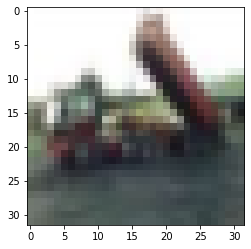

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.fromarray(train_images[2], 'RGB')
plt.imshow(img)

Vemos que la imagen, por más pixelada que esté, corresponde a un camión. Verifiquemos la etiqueta

In [0]:
label_names[train_labels[2][0]]

'truck'

Realizamos algunas tareas de preprocesamiento, normalizando las imágenes y transformando las etiquetas a one-hot-encoded:

In [0]:
from tensorflow.keras.utils import to_categorical

# Normalizamos:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Transformamos nuestras etiquetas multiclase en one hot:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [0]:
print ("train_labels shape: " + str(train_labels.shape))
print ("test_labels shape: " + str(test_labels.shape))

train_labels shape: (50000, 10)
test_labels shape: (10000, 10)


In [0]:
train_labels[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

## Inception Module

Definimos el módulo de inception.

Para crear un modelo, definamos primero un tensor input_img para una imagen de 32x32 con 3 canales (RGB):

In [0]:
from tensorflow.keras.layers import Input
input_img = Input(shape = (32, 32, 3))

Verifiquemos el tipo de dato de `input_img`

In [0]:
type(input_img)

tensorflow.python.framework.ops.Tensor

Este `Tensor` es el que tomará la forma de los inputs y se usará para alimentar las distintas capas del modelo.


Ahora, alimentamos el tensor de entrada a cada uno de los filtros 1x1, 3x3, 5x5 en el módulo de inception.

En este caso iremos "sobreescribiendo" cada resultado luego de aplicar las operaciones convolucionales.

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)

Veamos qué queda almacenado en cada una de las variables `tower`

In [0]:
type(tower_1)

tensorflow.python.framework.ops.Tensor

El resultado sigue siendo un tensor, como era de esperarse luego de aplicarle una operación a otro tensor. La información de esta operación también queda almacenada en el objeto.

In [0]:
tower_1.op # Muestra la operación que da como resultado este tensor.

<tf.Operation 'conv2d_1/Identity' type=Identity>

Luego podremos ver qué operaciones *consumen* a este vector como entrada.

Primero analicemos las dimensiones de los vectores generados luego de las operaciones definidas.

In [0]:
tower_1.shape, tower_2.shape, tower_3.shape

(TensorShape([None, 32, 32, 64]),
 TensorShape([None, 32, 32, 64]),
 TensorShape([None, 32, 32, 64]))

Aprendemos 64 filtros 1x1 en el tensor input_img y luego aprendemos 64 filtros 3x3 en el tensor tower_1. Creamos los tensores tower_2, tower_3 del mismo modo.
Nota: proporcionamos el tensor input_img a tower_2 y tower_3 como entrada para que todos los filtros 3x3, 5x5 y las capas de agrupación máxima se realicen en la misma entrada.
El padding es "same" para que la forma de salida de la operación Conv2D sea la misma que la forma de entrada. Entonces, la salida final de cada filtro de tower_1, tower_2 y tower_3 es la misma. Por lo tanto, podemos concatenar fácilmente estos filtros para formar la salida de nuestro módulo de inicio.

In [0]:
output = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

La operación de concatenación supone que las dimensiones de tower_1, tower_2, tower_3 son las mismas, excepto por el eje de concatenación.
Aplanamos la salida a una colección unidimensional de neuronas que luego se usa para crear una red neuronal densa como un clasificador final.

In [0]:
from tensorflow.keras.layers import Flatten, Dense
output = Flatten()(output)
out = Dense(10, activation='softmax')(output)

In [0]:
from tensorflow.keras.models import Model
model = Model(inputs = input_img, outputs = out)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 3)    0           input_1[0][0]                    
______________________________________________________________________________________________

Ahora que tenemos el modelo definido en su totalidad (es decir que ya vinculamos todas las operaciones que formarán el grafo computacional correspondiente a este modelo), podemos ver las conexiones de cada capa en particular. Previamente vimos que cada `Tensor` posee información de las operaciones que lo generaron. Ahora podemos ver qué operaciones lo necesitan como input.

In [0]:
tower_1.consumers()

[<tf.Operation 'concatenate/concat' type=ConcatV2>]

Analicemos las conexiones de la capa de salida:

In [0]:
out.op

<tf.Operation 'dense/Identity' type=Identity>

In [0]:
out.consumers()

[]

Como era de esperarse, `out` proviene de una capa densa con activación softmax y no es consumida por nadie. 

Procedamos a la compilación y entrenamiento del modelo.

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

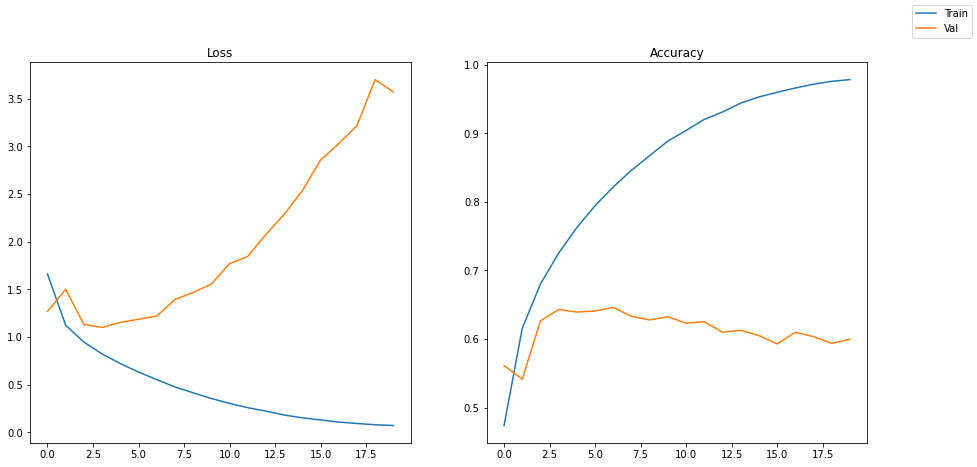

In [0]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss')
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy')
fig.legend(['Train', 'Val'])

In [0]:
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.6610 - accuracy: 0.4741 - val_loss: 1.2694 - val_accuracy: 0.5615
Epoch 2/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.1229 - accuracy: 0.6155 - val_loss: 1.4993 - val_accuracy: 0.5415
Epoch 3/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9465 - accuracy: 0.6802 - val_loss: 1.1306 - val_accuracy: 0.6264
Epoch 4/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8220 - accuracy: 0.7252 - val_loss: 1.1002 - val_accuracy: 0.6431
Epoch 5/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7213 - accuracy: 0.7625 - val_loss: 1.1532 - val_accuracy: 0.6394
Epoch 6/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.6322 - accuracy: 0.7943 - val_loss: 1.1859 - val_accuracy: 0.6409
Epoch 7/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5532 - accuracy: 0.8217 - val_loss: 1.2194 -

Evaluamos los resultados en el set de testeo:

In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 3.5283 - accuracy: 0.5929


In [0]:
test_acc

0.5928999781608582